## The goal of this notebook is to compare the models with various numbers of filters and fixed vs non-fixed filters for accuracy in recreating the relative vorticity

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, AveragePooling2D, Conv2DTranspose, Flatten, Reshape, Layer
from tensorflow.keras.models import Model, load_model
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split

In [2]:
#set the paths
data_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA'
figure_path = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/FIGURES/'
root = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2'

# set the seed
rand_seed = 144
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)

In [3]:
# Load in the variable filter model
var_filt_model = tf.keras.models.load_model(data_path + '/MODELS/trainable_model')
# Load in the fixed filter model
fix_filt_model = tf.keras.models.load_model(data_path + '/MODELS/nontrainable_model')

2023-11-10 09:36:46.972942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load in the Data and get out the corresponding validation and testing data that goes
# with my models
#bring in the data
os.chdir(data_path)
e5data = Dataset('ERA5_200hpa_U_V_relVort_Colorado_2021_2022.nc')
u = e5data.variables['u'][:]
v = e5data.variables['v'][:]
vort = e5data.variables['vo'][:]
lats = e5data.variables['latitude'][:]
lons = e5data.variables['longitude'][:]
time = e5data.variables['time'][:]
#convert times to usable dates
ref_date = dt.datetime(1900,1,1)
dates = np.array( [ ref_date + dt.timedelta(hours = int(t)) for t in time ] )

#let's limit the data
num_samples = 5000
time_start = np.random.randint(0,len(dates)-num_samples)
u = u[time_start:time_start+num_samples]
v = v[time_start:time_start+num_samples]
vort = vort[time_start:time_start+num_samples]
dates = dates[time_start:time_start+num_samples]

In [5]:
# normalize the data
def normalize_data(dataset:np.ndarray) -> np.ndarray:
    '''
        Normalizes data so that it is on the range 0-1 and then returns
        the normalized data.

        Inputs:
            dataset (np.ndarray): The dataset to be normalized
        
        Outputs:
            norm_data (np.ndarray): The normalized data
    '''

    data_min = np.nanmin(dataset)
    data_max = np.nanmax(dataset)

    norm_data = (dataset[:] - data_min) / (data_max - data_min)

    return norm_data, data_min, data_max

def denormalize_data(normed_data:np.ndarray,orig_min:float,orig_max:float) -> np.ndarray:
    '''
        De-normalizes a dataset using the min and max from the
        original dataset.

        Inputs:
            normed_data (np.ndarray): The dataset to be de-normalized, should
                have a range of [0-1]
            orig_min (float): The original minima of the dataset which was
                used to normalize it
            orig_max (float): The original maxima of the dataset which was
                used to normalize it
        
        Returns:
            denormed_data (np.ndarray): The denormalized dataset which should
                have a range of [orig_min,orig_max]
    '''

    denormed_data = (normed_data * (orig_max - orig_min)) + orig_min

    return denormed_data

u_norm,u_min,u_max = normalize_data(u)
v_norm,v_min,v_max = normalize_data(v)
vort_norm,vort_min,vort_max = normalize_data(vort)

In [6]:
# Combine u and v such that they are images with 2 "channels"
uv_data = np.empty((u.shape[0],u.shape[1],u.shape[2],2))
uv_data[:,:,:,0] = u_norm[:]
uv_data[:,:,:,1] = v_norm[:]
# uv_data is a 4D array of shape (time,lat,lon,channel)

# Split the data in testing/validation/training
# 10% will be testing
# 20% of the remainder will be validation
# the remainder of that will be training data


x_train,x_test,y_train,y_test = train_test_split(uv_data,vort_norm,test_size=0.1,
                                                 shuffle=True, random_state= rand_seed)
#now split off the validation from the training
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,
                                               shuffle = True,random_state= rand_seed)

# print the shapes to verify things look right
print("TRAINING, VALIDATION, AND TESTING SHAPES:")
print(f'XTRAIN: {x_train.shape}, XVAL: {x_val.shape}, XTEST: {x_test.shape}')
print(f'YTRAIN: {y_train.shape}, YVAL: {y_val.shape}, YTEST: {y_test.shape}')

TRAINING, VALIDATION, AND TESTING SHAPES:
XTRAIN: (3600, 25, 41, 2), XVAL: (900, 25, 41, 2), XTEST: (500, 25, 41, 2)
YTRAIN: (3600, 25, 41), YVAL: (900, 25, 41), YTEST: (500, 25, 41)


### Now Let's compare how well the models recreate the Validation Data

In [7]:
# have the models make predictions on the testing data
trainable_val = var_filt_model.predict(x_val).squeeze()
nontrainable_val = fix_filt_model.predict(x_val).squeeze()

29/29 [==============================] - 0s 2ms/step


In [8]:
# Set plot parameters
levs = np.arange(-1e-4,1e-4,5e-6)
cticks = [-1e-4,-5e-5,0,5e-5,1e-4]

dif_levs = np.arange(-1e-8,1.1e-8,1e-9)
dif_cticks = [-1e-8,-5e-9,0,5e-9,1e-8]

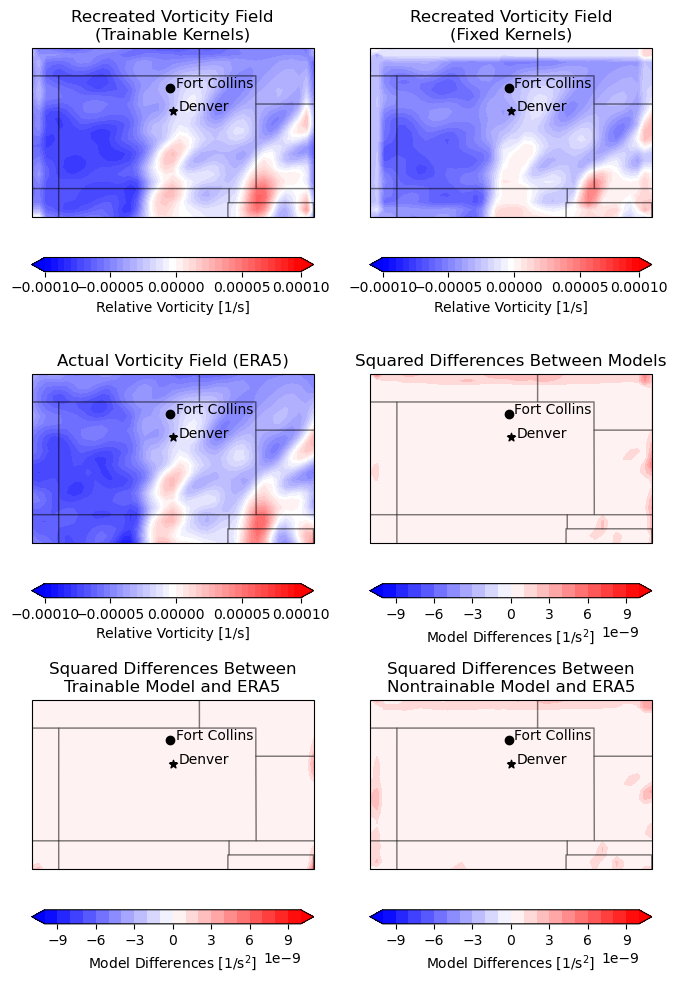

In [9]:

img = 80

tt_pred = denormalize_data(trainable_val[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_val[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_val[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

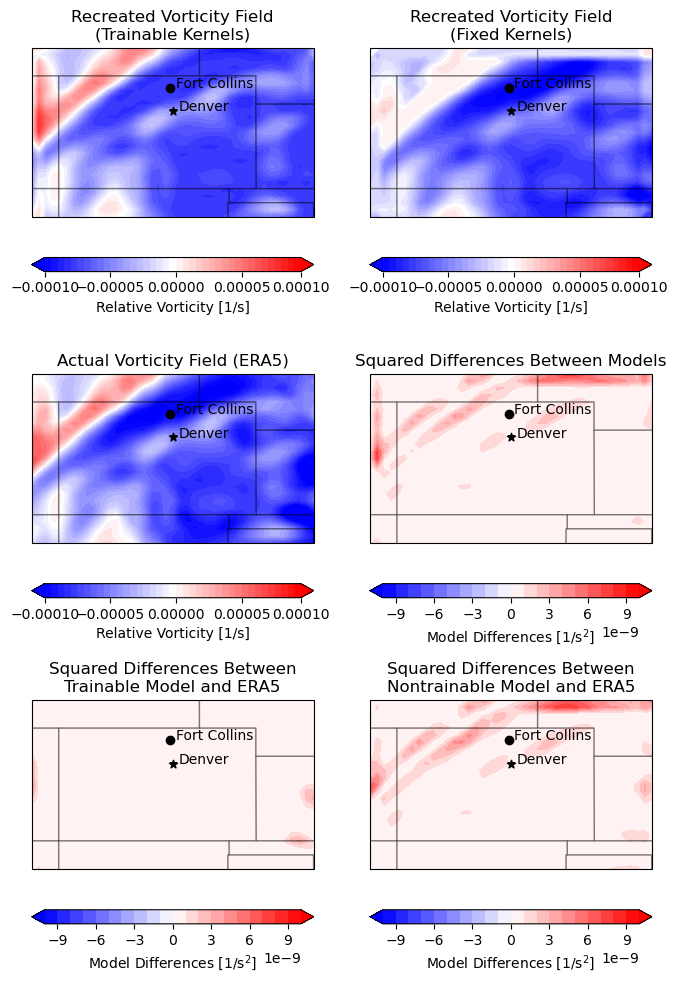

In [10]:

img = 200

tt_pred = denormalize_data(trainable_val[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_val[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_val[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

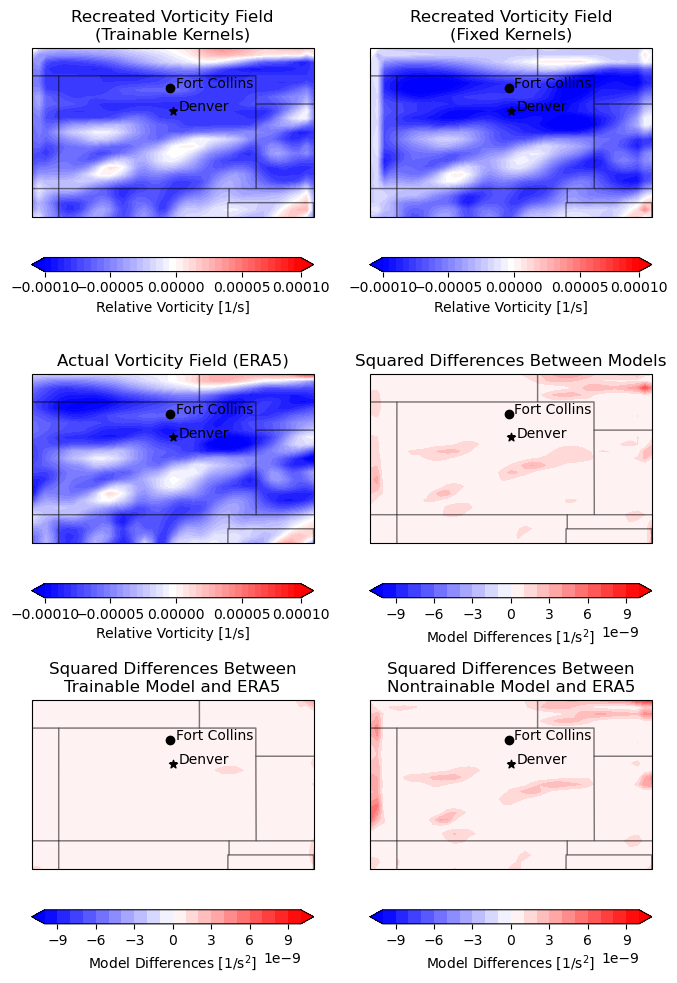

In [11]:

img = 400

tt_pred = denormalize_data(trainable_val[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_val[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_val[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

### Now Let's compare how well the models recreate the Testing Data

In [12]:
# have the models make predictions on the testing data
trainable_test = var_filt_model.predict(x_test).squeeze()
nontrainable_test = fix_filt_model.predict(x_test).squeeze()

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 3ms/step


In [13]:
# Set plot parameters
levs = np.arange(-1e-4,1e-4,5e-6)
cticks = [-1e-4,-5e-5,0,5e-5,1e-4]

dif_levs = np.arange(-1e-8,1.1e-8,1e-9)
dif_cticks = [-1e-8,-5e-9,0,5e-9,1e-8]

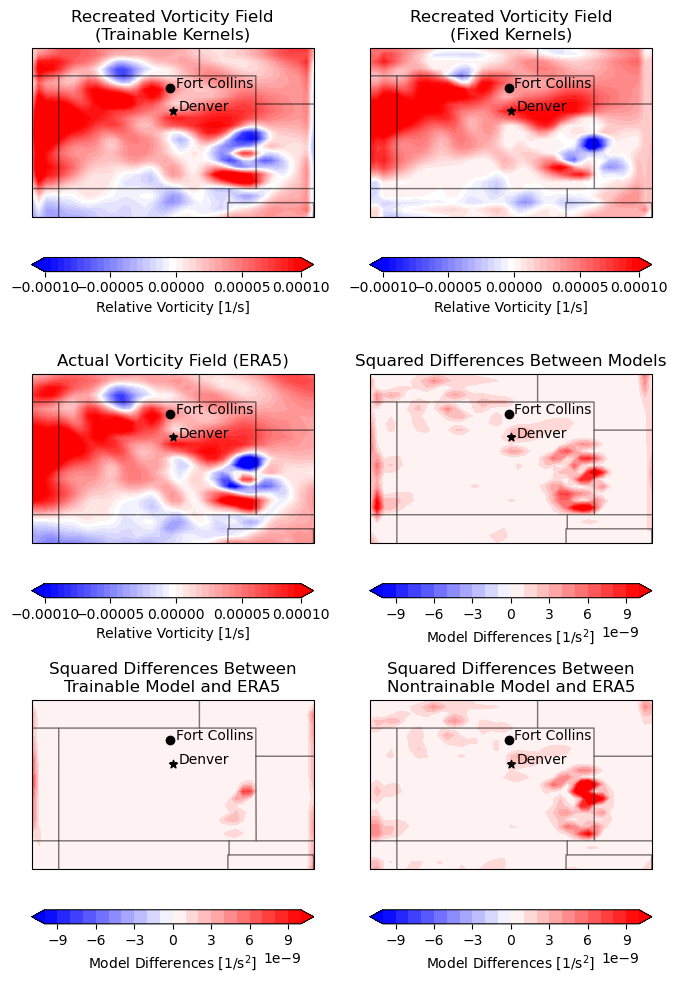

In [14]:

img = 80

tt_pred = denormalize_data(trainable_test[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_test[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_test[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

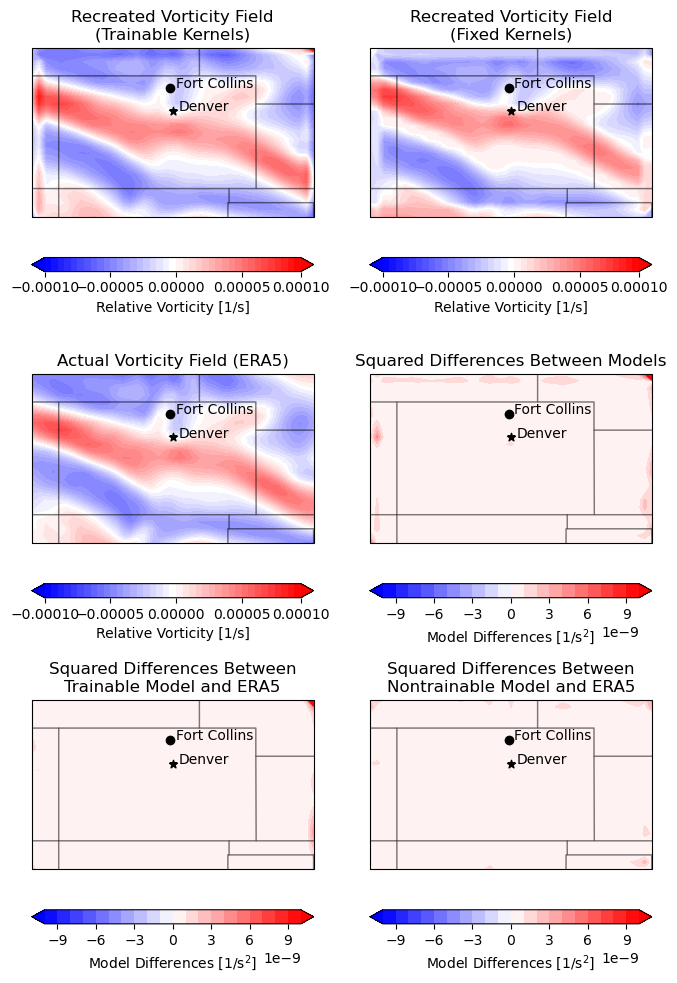

In [15]:

img = 200

tt_pred = denormalize_data(trainable_test[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_test[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_test[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

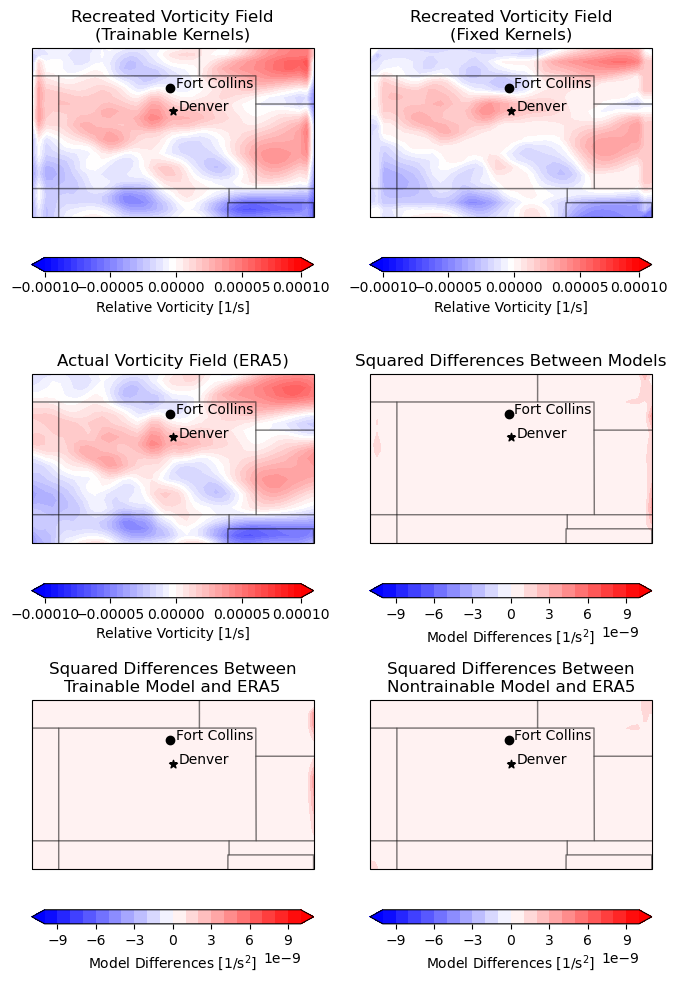

In [16]:

img = 400

tt_pred = denormalize_data(trainable_test[img],vort_min,vort_max)
nt_pred = denormalize_data(nontrainable_test[img],vort_min,vort_max)
actual = denormalize_data(ma.getdata(y_test[img]),vort_min,vort_max)
model_dif = (tt_pred - nt_pred)**2
actual_tt_dif = (actual - tt_pred)**2
actual_nt_dif = (actual - nt_pred)**2

fig,ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (8,12))

# Axis 0,0 is Variable Filter Model
ax[0,0].add_feature(cfeature.STATES,alpha = 0.3)
cf00 = ax[0,0].contourf(lons,lats,tt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf00,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,0].set_title('Recreated Vorticity Field\n(Trainable Kernels)')

# Axis 0,1 is Fixed Filter Model
ax[0,1].add_feature(cfeature.STATES,alpha = 0.3)
cf01 = ax[0,1].contourf(lons,lats,nt_pred,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf01,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[0,1].set_title('Recreated Vorticity Field\n(Fixed Kernels)')

# Axis 1,0 is Actual Vorticity
ax[1,0].add_feature(cfeature.STATES,alpha = 0.3)
cf10 = ax[1,0].contourf(lons,lats,actual,levels = levs,extend = 'both',cmap = 'bwr')
plt.colorbar(cf10,orientation = 'horizontal',ticks = cticks, label = 'Relative Vorticity [1/s]')
ax[1,0].set_title('Actual Vorticity Field (ERA5)')

# Axis 1,1 is the differences between the models squared
ax[1,1].add_feature(cfeature.STATES,alpha = 0.3)
cf11 = ax[1,1].contourf(lons,lats,model_dif,extend = 'both',cmap = 'bwr',levels = dif_levs)
plt.colorbar(cf11,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[1,1].set_title('Squared Differences Between Models')

# Axis 2,0 is the difference between the Var Filt Model and the Actual Squared
ax[2,0].add_feature(cfeature.STATES,alpha = 0.3)
cf20 = ax[2,0].contourf(lons,lats,actual_tt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf20,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,0].set_title('Squared Differences Between\nTrainable Model and ERA5')

# Axis 2,1 is the difference between the Fix Filt Model and the Actual Squared
ax[2,1].add_feature(cfeature.STATES,alpha = 0.3)
cf21 = ax[2,1].contourf(lons,lats,actual_nt_dif,extend = 'both',cmap = 'bwr', levels = dif_levs)
plt.colorbar(cf21,orientation = 'horizontal',label = 'Model Differences [1/s$^2$]')
ax[2,1].set_title('Squared Differences Between\nNontrainable Model and ERA5')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')


plt.show()

In [17]:
# let's look at MSE on the testing data for both models
tt_se = np.empty((x_test.shape[0]))
nt_se = np.empty((x_test.shape[0]))

for i in range(x_test.shape[0]):
    tt_pred = denormalize_data(trainable_test[i],vort_min,vort_max)
    nt_pred = denormalize_data(nontrainable_test[i],vort_min,vort_max)
    actual = denormalize_data(ma.getdata(y_test[i]),vort_min,vort_max)
    actual_tt_MSE = np.mean((actual - tt_pred)**2)
    actual_nt_MSE = np.mean((actual - nt_pred)**2)

    tt_se[i] = actual_tt_MSE
    nt_se[i] = actual_nt_MSE


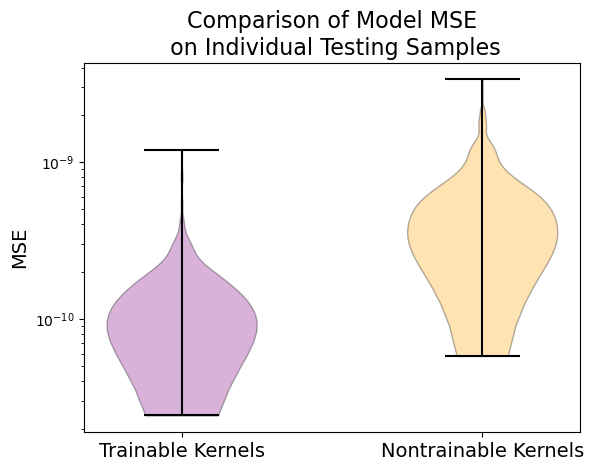

In [59]:
boxes = [tt_se,nt_se]

vc = plt.violinplot(boxes)

vc['bodies'][0].set_facecolor("purple")
vc['bodies'][1].set_facecolor("orange")
vc["bodies"][0].set_edgecolor("k")
vc["bodies"][1].set_edgecolor("k")

vc['cbars'].set_colors('k')
vc['cmaxes'].set_colors('k')
vc['cmins'].set_colors('k')

plt.yscale('log')
plt.xticks([1,2],["Trainable Kernels","Nontrainable Kernels"],fontsize = 14)
plt.ylabel("MSE",fontsize = 14)
plt.title("Comparison of Model MSE\n on Individual Testing Samples",fontsize = 16)
#plt.ylim(1e-11,8e-9)

os.chdir(figure_path)
plt.savefig("MSE_VIOLIN_PLOT_TESTING_SAMPLES.png",dpi = 400,bbox_inches = 'tight')
plt.show()